In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
import pickle
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf

Using TensorFlow backend.


## Prepare Text Data

In [2]:
# Load text data
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

path = "Flickr_Data\Flickr_TextData\Flickr8k.token.txt"
doc = load_doc(path)
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [3]:
# Load description in dictionary 
def load_description(doc):
    mapping = {}
    for line in doc.split("\n"):
        token = line.split()
        if len(line) < 2:
            continue
        image_id = token[0]
        image_id = image_id.split(".")[0]
        
        image_desc = token[1:]
        image_desc = " ".join(image_desc)
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
        
    return mapping

descriptions = load_description(doc)
print("length of images :",len(descriptions))
print("-----------------------------------")
descriptions["1000268201_693b08cb0e"]

length of images : 8092
-----------------------------------


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [4]:
# Clean the description (lower case, punctuation, stop word, get rid numeric value)
from nltk.tokenize import word_tokenize
import string
def clean_description(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, img_desc in descriptions.items():
        for i in range(len(img_desc)):
            desc = img_desc[i]
            desc = word_tokenize(desc)
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            img_desc[i] =  ' '.join(desc)
clean_description(descriptions)
print(len(descriptions))
print("---------------------------")
descriptions["1000268201_693b08cb0e"]

8092
---------------------------


['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [5]:
# store the vocabulary from the description
def vacobulary_(descriptions):
    store_vacob = set()
    for key in descriptions.keys():
        for i in descriptions[key]:
            store_vacob.update(i.split())
    return store_vacob
vacobulary = vacobulary_(descriptions)
len(vacobulary)

8761

In [6]:
# Save the clean description in local directory with name of "description.txt"
def save_description(descriptions, file_name):
    lines = []
    for key, img_desc in descriptions.items():
        for desc in img_desc:
            lines.append(key + " " + desc)
    data = "\n".join(lines)
    files = open(file_name, "w")
    files.write(data)
    files.close()

save_description(descriptions, "final_description.txt")

=====================================================================================================================

## Prepare Image Data

In [7]:
# Load a predifine list of train image data
def load_set(filename):
    doc = load_doc(filename)
    dataset = []
    for line in doc.split("\n"):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)
file_name_path = "Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt"
train = load_set(file_name_path)
print(len(train))

6000


In [8]:
# Load image data
images = 'Flickr_Data\Images'
# img = glob.glob(images)
img = os.listdir(images)
# glob(join(images, )
len(images)

18

In [9]:
# File conatains the names of images to be used in train data
train_images_file = 'Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img:
    if i in train_images:
        train_img.append(i)
len(train_img)

6000

In [10]:
# File conatains the names of images to be used in train data
test_images_file = 'Flickr_Data\Flickr_TextData\Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img:
    if i in test_images:
        test_img.append(i)
len(test_img)

1000

In [11]:
# Image Preprocessing
def preprocess(image_path):
#     r"F:/Coding Ninjas ML/Projects/20_newsgroups/"+category
    path = r'Flickr_Data/Images/' + image_path
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

##### Used pretrained model of image encoding "InceptionV3"

In [12]:
# i = "1000268201_693b08cb0e.jpg"
# path__ = r"Flickr_Data/Images/" +i 
# image.load_img(r'Flickr_Data\Images\1000268201_693b08cb0e.jpg', target_size=(299, 299))
# image.load_img(path__, target_size=(299, 299))
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [16]:
# model_new.summary()

In [17]:
# Image Encoding
from time import time
def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [61]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 2286.4507880210876


In [62]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [51]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 378.1686954498291


In [53]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

===================================================================================================================

#### images processing done

In [18]:
# Final feature from images...
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
train_features["1001773457_577c3a7d70.jpg"]

Photos: train=6000


array([0.7366835 , 0.5911323 , 0.18194222, ..., 0.16030245, 0.34144688,
       0.9083169 ], dtype=float32)

#### text cleaning done 

In [13]:
# Final clean description
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

train_descriptions = load_clean_descriptions('final_description.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
train_descriptions["1001773457_577c3a7d70"]

Descriptions: train=6000


['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Develop Deep Learning Model


In [14]:
# create a list of all traning 
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)
# all_train_captions

30000

In [19]:
# Consider only words which occur at least 10 times in the corpus
print("Consider only words which occur at least 10 times in the corpus.\n")
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))


Consider only words which occur at least 10 times in the corpus.

preprocessed words 7576 -> 1651


In [16]:
import csv
with open('vocab.csv', 'w') as f:
    for c in vocab:
        f.write(str(c))
        f.write("\n")

In [17]:
# Giving index no. to vocabulary of each words
ixtoword = {}
wordtoix = {}
ix = 1
for word in vocab:
    ixtoword[ix] = word
    wordtoix[word] = ix
    ix += 1
print(ixtoword[1])
print(wordtoix["startseq"])


startseq
1


In [23]:
vocab_size = len(ixtoword) + 1
vocab_size

1652

In [24]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [25]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [26]:
# generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)

In [27]:
glove_dir = 'F:\Coding Ninjas ML\Projects\Image Captioning'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [28]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [29]:
embedding_matrix.shape

(1652, 200)

In [100]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 200)      330400      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [108]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [102]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [103]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [111]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save('./Model Saves/model_' + str(i) + '.h5') 

Epoch 1/1
2000/2000 [==============================] - 801s 400ms/step - loss: 2.5122
Epoch 1/1
2000/2000 [==============================] - 881s 440ms/step - loss: 2.5018
Epoch 1/1
2000/2000 [==============================] - 990s 495ms/step - loss: 2.4958
Epoch 1/1
2000/2000 [==============================] - 903s 451ms/step - loss: 2.4831
Epoch 1/1
2000/2000 [==============================] - 979s 489ms/step - loss: 2.4765
Epoch 1/1
2000/2000 [==============================] - 1020s 510ms/step - loss: 2.4693
Epoch 1/1
2000/2000 [==============================] - 979s 490ms/step - loss: 2.4614
Epoch 1/1
2000/2000 [==============================] - 990s 495ms/step - loss: 2.4581
Epoch 1/1
2000/2000 [==============================] - 876s 438ms/step - loss: 2.4475
Epoch 1/1
2000/2000 [==============================] - 810s 405ms/step - loss: 2.4436


In [112]:
# this model is saved after 31 epochs
model.save('./Model Saves/model_31.h5') 

In [4]:
from keras.models import load_model
model_1 = load_model("Model Saves\model_31.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## Model Prediction

In [30]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [31]:
list(encoding_test.keys())[1]

'106490881_5a2dd9b7bd.jpg'

In [34]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_1.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

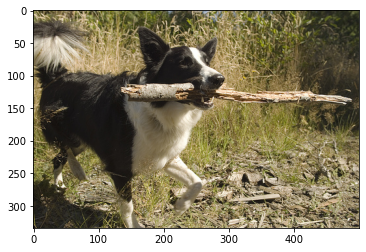

'black and white dog is running through the grass'

In [35]:
photo =  list(encoding_test.keys())[22]
x = plt.imread("Flickr_Data\Images/" + photo)
plt.imshow(x)
plt.show()
greedySearch(encoding_test[photo].reshape((1,2048)))
